In [1]:
import seaborn as sns
from scipy.stats import skew, kurtosis, spearmanr, pearsonr
from enformer_pytorch import Enformer
import torch
import time
import numpy as np
from pyfaidx import Fasta
import glob
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os
warnings.filterwarnings("ignore")


founders = ['A_J.39',         'C57BL_6J.39',
            '129S1_SvImJ.39', 'NOD_ShiLtJ.39',
            'NZO_HlLtJ.39',   'CAST_EiJ.39',
            'PWK_PhJ.39',     'WSB_EiJ.39']


SEQ_LEN = 196608
BIN_SIZE= 128
SEQ_LEN_DIV_BY2 = SEQ_LEN//2

one_hot_embed = torch.zeros(256, 4)
one_hot_embed[ord('a')] = torch.Tensor([1., 0., 0., 0.])
one_hot_embed[ord('c')] = torch.Tensor([0., 1., 0., 0.])
one_hot_embed[ord('g')] = torch.Tensor([0., 0., 1., 0.])
one_hot_embed[ord('t')] = torch.Tensor([0., 0., 0., 1.])
one_hot_embed[ord('n')] = torch.Tensor([0., 0., 0., 0.])
one_hot_embed[ord('A')] = torch.Tensor([1., 0., 0., 0.])
one_hot_embed[ord('C')] = torch.Tensor([0., 1., 0., 0.])
one_hot_embed[ord('G')] = torch.Tensor([0., 0., 1., 0.])
one_hot_embed[ord('T')] = torch.Tensor([0., 0., 0., 1.])
one_hot_embed[ord('N')] = torch.Tensor([0., 0., 0., 0.])
one_hot_embed[ord('.')] = torch.Tensor([0.25, 0.25, 0.25, 0.25])

def cast_list(t):
    return t if isinstance(t, list) else [t]
def torch_fromstring(seq_strs):
    batched = not isinstance(seq_strs, str)
    seq_strs = cast_list(seq_strs)
    np_seq_chrs = list(map(lambda t: np.fromstring(t, dtype = np.uint8), seq_strs))
    seq_chrs = list(map(torch.from_numpy, np_seq_chrs))
    return torch.stack(seq_chrs) if batched else seq_chrs[0]
def str_to_one_hot(seq_strs):
    seq_chrs = torch_fromstring(seq_strs)
    return one_hot_embed[seq_chrs.long()]
                         
def copy_fa_to_fastscratch(strain,temp_dir):
    gtf_filepath = "/projects/compsci/omics_share/mouse/GRCm39/transcriptome/annotation/imputed/rel_2112_v8/"
    shutil.copy(gtf_filepath + strain +  ".fa", temp_dir)

def get_enformer_prediction_per_gene(gene_id, gtf, seqs, idx, SEQ_LEN=SEQ_LEN, offset=0): 
    SEQ_LEN = SEQ_LEN + offset 
    SEQ_LEN_DIV_BY2 = SEQ_LEN//2
    select = gtf[gtf.gene_id == gene_id]
    print(select)
    chromo = select.chr.values[0]
    n_seq = len(seqs)
    start = select.start.values[0] - 1 # python index starts from 0
    end = select.end.values[0] - 1 # python index starts from 0
    if start > SEQ_LEN_DIV_BY2:
        cut_start = start - SEQ_LEN_DIV_BY2
        pred_loc = (SEQ_LEN_DIV_BY2 + 1)//BIN_SIZE
    else:
        cut_start = 0
        pred_loc  = (start + 1)//BIN_SIZE
    cut_end = min(n_seq, start + SEQ_LEN_DIV_BY2) 
    one_hot = str_to_one_hot(np.array(seqs)[cut_start:cut_end])
    print("cut seq from ", cut_start, " to", cut_end, ". length: ", cut_end - cut_start)
    target_length= (cut_end-cut_start+1)//BIN_SIZE
    
    enformer = Enformer.from_pretrained('EleutherAI/enformer-official-rough')
    enformer.eval()
    pred = enformer(one_hot,target_length = target_length, head="mouse").detach().numpy()[0]
    print("target_length: ", target_length, " pred_loc", pred_loc, " pred shape:", pred.shape)
    return pred[:, idx]

def get_enformer_prediction(gene_id, idx, strains=founders):
    res = {}   
    for strain in strains:
        ref_path = "/fastscratch/chenm/" + strain + ".fa"
        if not os.path.isfile(ref_path):
            copy_fa_to_fastscratch(strain, "/fastscratch/chenm/")  
        print("ref_path:", ref_path)
        gtf_filepath = "/projects/compsci/vmp/USERS/chenm/mahoney/enformer/gtf_data/"
        gtf_filepath = gtf_filepath + os.path.basename(ref_path).replace("fa", "gtf")
        print("gtf_path:", gtf_filepath)
        gtf = pd.read_csv(gtf_filepath)
        chrome = gtf[gtf.gene_id == gene_id]["chr"].values[0]
        seqs = Fasta(ref_path)[chrome]
        res[strain] = get_enformer_prediction_per_gene(gene_id, gtf, seqs, idx)
    res = pd.DataFrame(res)#.to_csv(output_file)
    return res


/home/chenm/.local/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


# Load enformer prediction results

In [2]:
df = pd.read_csv("/projects/compsci/vmp/USERS/chenm/mahoney/enformer/results/df_enformer_results_combined.csv")
print(df.shape)
df.head()


(257290, 1646)


,gene_id,strain,chr,0,1,2,3,4,5,6,...,1633,1634,1635,1636,1637,1638,1639,1640,1641,1642
0,ENSMUSG00000102095,A_J.39,1,0.040924,0.056700,0.067874,0.067091,0.080475,0.083420,0.112752,...,0.075877,0.037519,0.042378,0.011139,0.015951,0.020407,0.153650,0.295805,0.506962,0.447128
1,ENSMUSG00000100635,A_J.39,1,0.050041,0.088189,0.073688,0.074054,0.095278,0.135458,0.078608,...,0.131363,0.066115,0.042751,0.013250,0.015378,0.016447,0.163415,0.289335,0.503353,0.463163
2,ENSMUSG00000100480,A_J.39,1,0.084338,0.113319,0.102513,0.118447,0.127997,0.180727,0.117222,...,0.078001,0.074148,0.056194,0.016264,0.025024,0.027550,0.186570,0.388947,0.630922,0.580891
3,ENSMUSG00000051285,A_J.39,1,11.406491,7.716231,15.528511,17.759916,9.733851,8.122746,8.890949,...,31.664043,17.077888,27.121246,16.581524,5.318263,8.928493,113.247280,62.031834,168.752290,112.973870
4,ENSMUSG00000097797,A_J.39,1,0.038032,0.050995,0.061002,0.057124,0.064742,0.054396,0.067352,...,0.022418,0.023875,0.019316,0.006881,0.010625,0.011407,0.059720,0.137251,0.210507,0.212218


# Get track index 

In [3]:
xls_file = pd.ExcelFile('/projects/compsci/vmp/USERS/chenm/mahoney/41592_2021_1252_MOESM3_ESM.xlsx')
table3 = pd.read_excel(xls_file, 'Supplementary Table 3')
#table_kidney = table3[table3["target"].str.contains("CAGE.*kidney", case=False)]


idx_kidney = int(table3[table3["target"] == "CAGE/kidney, neonate N30"]["index"].values[0])
print("index for CAGE/kidney, neonate N30: ", idx_kidney)
idx_liver = int(table3[table3["target"] == "CAGE/liver, adult pregnant day01"]["index"].values[0])
print("index for CAGE/liver, adult pregnant day01: ", idx_liver)



index for CAGE/kidney, neonate N30:  1486
index for CAGE/liver, adult pregnant day01:  1288


In [4]:
def prepare_data(df, idx, coef_file):
    df1 = df[["gene_id", "strain", str(idx)]]
    df1 = df1.pivot(index='gene_id', columns='strain', values=str(idx))
    df1 = df1.rename_axis(None, axis=1)
    df1.index.name = None
    df1 = df1[founders]
    
    # load QTL allele effects   
    c2eff = pd.read_csv(coef_file, index_col=0)
    c2eff.index.name = None
    
    # subset common genes 
    df1 = df1.dropna()
    gene_list = list(set(df1.index) & set(c2eff.index))
    df1 = df1.loc[gene_list]     
    c2eff = c2eff.loc[gene_list]
    print("df1 shape: ", df1.shape)
    return df1, c2eff
    

def cal_corrcoefs(df1, c2eff, strains):
    spearman_corr = df1[strains].corrwith(other=c2eff[strains], method="spearman",  axis=1)
    spearman_corr = pd.DataFrame(spearman_corr, columns=["spearman_corr"])

    print("Skew (spearman corr): ", skew(spearman_corr.spearman_corr, axis=0, bias=True))
    print("Kurtosis (spearman corr): ", kurtosis(spearman_corr.spearman_corr, axis=0, bias=True))

    pearson_corr = df1[strains].corrwith(other=c2eff[strains], method="pearson",  axis=1)
    pearson_corr = pd.DataFrame(pearson_corr, columns=["pearson_corr"])
    sns.displot(spearman_corr, kde=True, bins=30) #.set(title='Spearman Corrcoef Distribution')
    sns.displot(pearson_corr, kde=True, bins=30)#.set(title='Pearson Corrcoef Distribution')

    print("Skew (pearson corr): ", skew(pearson_corr.pearson_corr, axis=0, bias=True))
    print("Kurtosis (pearson corr): ", kurtosis(pearson_corr.pearson_corr, axis=0, bias=True))
    return spearman_corr, pearson_corr
    
def plot_bin_corr(pearson_corr,spearman_corr, pred_loc):
    fig = plt.figure()
    ax1 = fig.add_subplot(221)
    ax1.plot(pearson_corr)
    ax1.set_title("Pearson correlation")
    ax2 = fig.add_subplot(222)
    ax2.plot(spearman_corr)
    ax2.set_title("Spearman ranking correlation")
    ax3 = fig.add_subplot(223)
    n=50
    ax3.plot(range(pred_loc-n, pred_loc+n), pearson_corr[pred_loc-n:pred_loc+n])
    ax3.set_title("Pearson correlation")
    ax3.axvline(x = pred_loc, color = 'lightgrey', ls='--')
    ax4 = fig.add_subplot(224)
    ax4.plot(range(pred_loc-n, pred_loc+n), spearman_corr[pred_loc-n:pred_loc+n])
    ax4.set_title("Spearman ranking correlation")
    ax4.axvline(x = pred_loc, color = 'lightgrey', ls='--')

    fig.suptitle(gene_id)
    plt.tight_layout()
    plt.show()

    
def cal_bin_corr(res, gene_id, c2eff, pred_loc, strains = founders):
    effect = c2eff.loc[gene_id][strains]
    spearman_bin_corr = []
    pearson_bin_corr = []
    
    for i in range(res.shape[0]):
        spearman_bin_corr.append(spearmanr(res.iloc[i].values, effect.values)[0])
    
    for i in range(res.shape[0]):
        pearson_bin_corr.append(pearsonr(res.iloc[i].values, effect.values)[0])
    
    print("Spearman ranking correlation at bin ", pred_loc, ":",  spearman_bin_corr[pred_loc])
    print("Pearson correlation at bin: ", pred_loc, ":", pearson_bin_corr[pred_loc])
    plot_bin_corr(spearman_bin_corr,pearson_bin_corr, pred_loc)


# Kidney JAC_DO_kidney.v6

df1 shape:  (19122, 8)
Skew (spearman corr):  -0.06195511814324278
Kurtosis (spearman corr):  -0.7997710985361794
Skew (pearson corr):  -0.06150351513475343
Kurtosis (pearson corr):  -0.9970694936068933


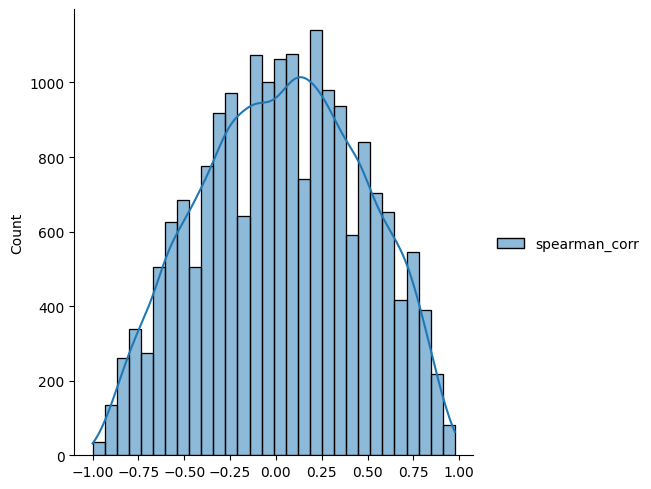

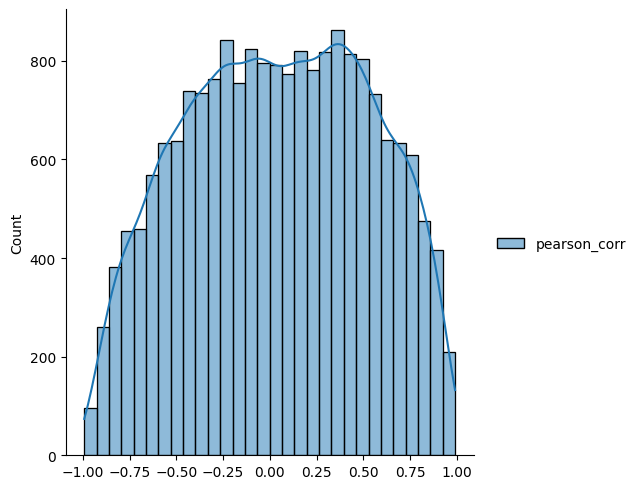

In [5]:
df1, c2eff = prepare_data(df, idx_kidney, "/projects/compsci/vmp/USERS/chenm/mahoney/enformer/kidney_v6_coef.csv")
spearman_corr, pearson_corr = cal_corrcoefs(df1, c2eff, founders)


,lod,A_J.39,C57BL_6J.39,129S1_SvImJ.39,NOD_ShiLtJ.39,NZO_HlLtJ.39,CAST_EiJ.39,PWK_PhJ.39,WSB_EiJ.39,pearson_corr,spearman_corr
ENSMUSG00000020268,87.107696,-1.269550,-0.516009,-1.468201,-1.295640,2.301587,0.906546,2.107967,-0.766699,0.573351,0.809524
ENSMUSG00000052031,80.197794,1.455988,1.941445,-1.208912,1.560130,-1.166615,-0.525993,-0.313760,-1.742281,-0.819367,-0.833333
ENSMUSG00000024026,79.672342,2.714046,-0.929445,0.992963,-1.228686,-0.945597,0.893836,-0.389853,-1.107263,-0.489681,-0.547619
ENSMUSG00000034101,79.355604,0.213264,-1.241970,-1.109955,-1.012689,-1.702809,-0.410517,4.005711,1.258964,-0.981031,-0.880952
ENSMUSG00000027597,79.010998,1.250213,1.357679,-1.298385,-1.307179,-1.121953,0.915108,1.367307,-1.162789,-0.325399,-0.380952


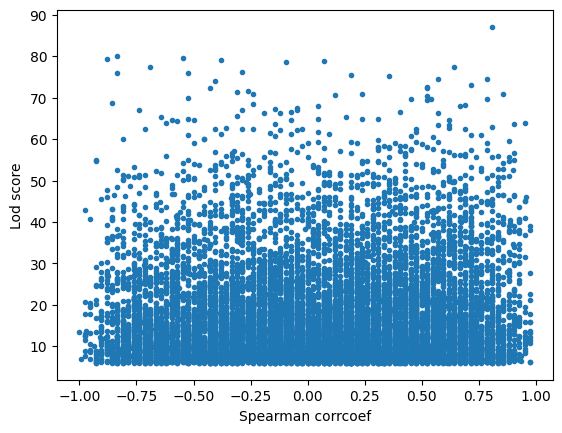

In [6]:
c2eff1 = c2eff.copy()
c2eff1 = c2eff1.join(pearson_corr)
c2eff1 = c2eff1.join(spearman_corr)
c2eff1 = c2eff1.sort_values(["lod"], ascending=False)
c2eff1.to_csv("/projects/compsci/vmp/USERS/chenm/mahoney/enformer/results/c2eff_kidney.csv")
c2eff2 = c2eff1[c2eff1.lod != -1] # -1 means no we don't have lod score for the gene
plt.plot(c2eff2["spearman_corr"],c2eff2["lod"], "." ) 
plt.xlabel("Spearman corrcoef")
plt.ylabel("Lod score")
c2eff2.head()

## Check ACE2, ENSMUSG00000015405  X_164140708  24.710368

In [7]:
gene_id = "ENSMUSG00000015405"
res_ace2 = get_enformer_prediction(gene_id, idx_kidney)

ref_path: /fastscratch/chenm/A_J.39.fa
gtf_path: /projects/compsci/vmp/USERS/chenm/mahoney/enformer/gtf_data/A_J.39.gtf
     chr      start        end             gene_id gene_name
4996   X  162903193  162952295  ENSMUSG00000015405      Ace2
cut seq from  162804888  to 163001496 . length:  196608
target_length:  1536  pred_loc 768  pred shape: (1536, 1643)
ref_path: /fastscratch/chenm/C57BL_6J.39.fa
gtf_path: /projects/compsci/vmp/USERS/chenm/mahoney/enformer/gtf_data/C57BL_6J.39.gtf
     chr      start        end             gene_id gene_name
4998   X  162922328  162971416  ENSMUSG00000015405      Ace2
cut seq from  162824023  to 163020631 . length:  196608
target_length:  1536  pred_loc 768  pred shape: (1536, 1643)
ref_path: /fastscratch/chenm/129S1_SvImJ.39.fa
gtf_path: /projects/compsci/vmp/USERS/chenm/mahoney/enformer/gtf_data/129S1_SvImJ.39.gtf
     chr      start        end             gene_id gene_name
4996   X  162915248  162964328  ENSMUSG00000015405      Ace2
cut seq from  

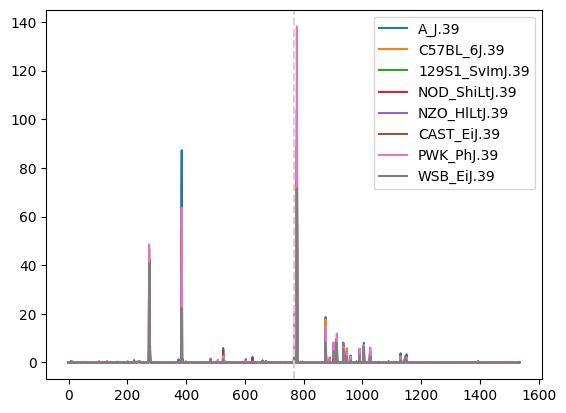

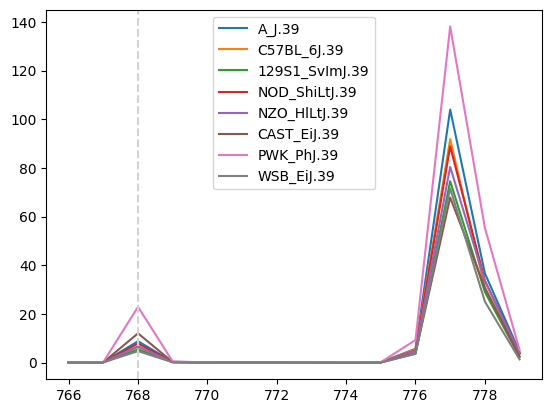

In [9]:
res_ace2.plot()
pred_loc =768 
plt.axvline(x = pred_loc, color = 'lightgrey', ls='--')
res_ace2.iloc[pred_loc-2:pred_loc+12].plot()
plt.axvline(x = pred_loc, color = 'lightgrey', ls='--')


Spearman ranking correlation at bin  768 : 0.07142857142857144
Pearson correlation at bin:  768 : 0.8042169309797323


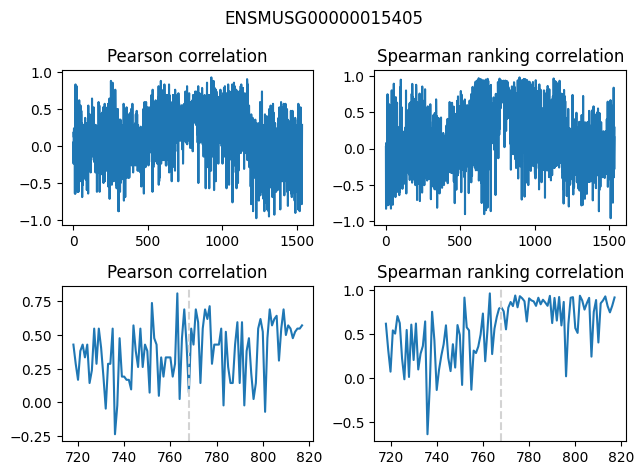

In [10]:
cal_bin_corr(res_ace2, gene_id, c2eff, pred_loc)

In [11]:
## Check if the results consistant (spearman_bin_corr[pred_loc] vs spearman_corr)
print(spearman_corr.loc[gene_id])
print(pearson_corr.loc[gene_id])

spearman_corr    0.071429
Name: ENSMUSG00000015405, dtype: float64
pearson_corr    0.804217
Name: ENSMUSG00000015405, dtype: float64


# Liver Svenson HFD DO

df1 shape:  (11206, 8)
Skew (spearman corr):  -0.097456105899431
Kurtosis (spearman corr):  -0.8374559041192624
Skew (pearson corr):  -0.11024658761874535
Kurtosis (pearson corr):  -1.0683452798743929


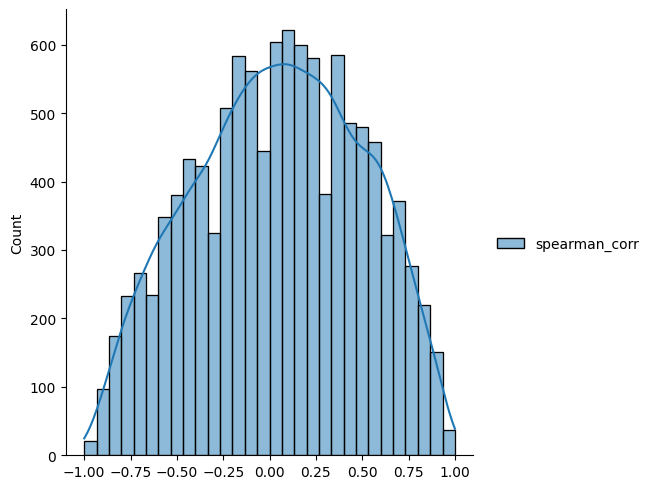

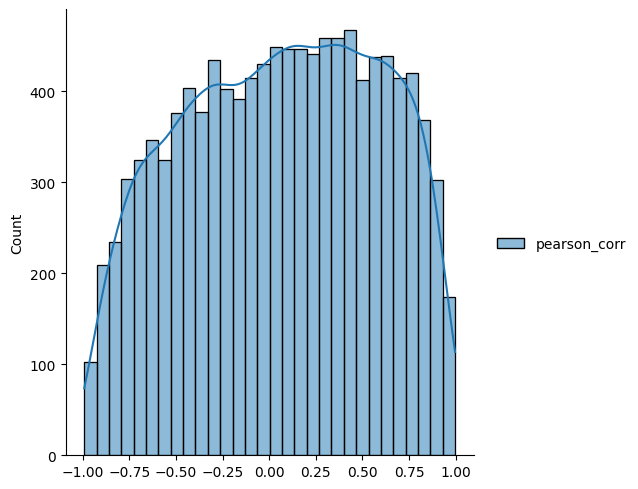

In [12]:
df1, c2eff = prepare_data(df, idx_liver, "/projects/compsci/vmp/USERS/chenm/mahoney/enformer/liver_Svenson_coef.csv")
spearman_corr, pearson_corr = cal_corrcoefs(df1, c2eff, founders)

,lod,A_J.39,C57BL_6J.39,129S1_SvImJ.39,NOD_ShiLtJ.39,NZO_HlLtJ.39,CAST_EiJ.39,PWK_PhJ.39,WSB_EiJ.39,pearson_corr,spearman_corr
ENSMUSG00000060441,219.406242,-1.529422,-0.226830,-1.603182,-0.329220,2.120993,0.941021,-0.866122,1.492763,0.857101,0.738095
ENSMUSG00000073555,216.274378,1.212542,1.719579,-0.224688,-0.947920,-1.528650,-1.761306,0.017892,1.512552,0.397310,0.500000
ENSMUSG00000027014,197.717793,-0.321743,-0.348964,-0.336518,-0.064616,-0.441042,0.013664,-0.731149,2.230369,-0.598681,-0.523810
ENSMUSG00000042251,197.688993,-1.077446,-1.221208,-0.157410,-1.072730,0.059524,0.202026,0.886693,2.380552,0.930559,0.785714
ENSMUSG00000020268,185.348308,-1.306453,-0.215987,-1.430020,-1.357200,1.788697,1.214777,2.075131,-0.768945,0.587003,0.476190


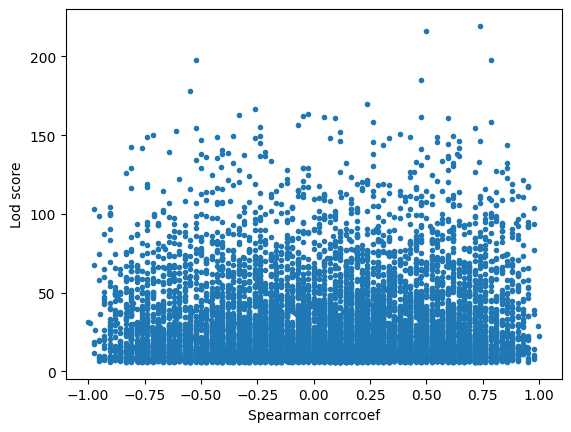

In [13]:
c2eff1 = c2eff.copy()
c2eff1 = c2eff1.join(pearson_corr)
c2eff1 = c2eff1.join(spearman_corr)
c2eff1 = c2eff1.sort_values(["lod"], ascending=False)
c2eff1.to_csv("/projects/compsci/vmp/USERS/chenm/mahoney/enformer/results/c2eff_liver.csv")
c2eff2 = c2eff1[c2eff1.lod != -1] # -1 means no we don't have lod score for the gene
plt.plot(c2eff2["spearman_corr"],c2eff2["lod"], "." ) 
plt.xlabel("Spearman corrcoef")
plt.ylabel("Lod score")
c2eff2.head()

In [14]:
# Check Trim5 ENSMUSG00000060441 tripartite motif-containing 5
gene_id = "ENSMUSG00000060441"
res_Trim5 = get_enformer_prediction(gene_id, idx_liver)

ref_path: /fastscratch/chenm/A_J.39.fa
gtf_path: /projects/compsci/vmp/USERS/chenm/mahoney/enformer/gtf_data/A_J.39.gtf
      chr      start        end             gene_id gene_name
12280   7  103884120  103908828  ENSMUSG00000060441     Trim5
cut seq from  103785815  to 103982423 . length:  196608
target_length:  1536  pred_loc 768  pred shape: (1536, 1643)
ref_path: /fastscratch/chenm/C57BL_6J.39.fa
gtf_path: /projects/compsci/vmp/USERS/chenm/mahoney/enformer/gtf_data/C57BL_6J.39.gtf
      chr      start        end             gene_id gene_name
12282   7  103912593  103937301  ENSMUSG00000060441     Trim5
cut seq from  103814288  to 104010896 . length:  196608
target_length:  1536  pred_loc 768  pred shape: (1536, 1643)
ref_path: /fastscratch/chenm/129S1_SvImJ.39.fa
gtf_path: /projects/compsci/vmp/USERS/chenm/mahoney/enformer/gtf_data/129S1_SvImJ.39.gtf
      chr      start        end             gene_id gene_name
12280   7  103884836  103909544  ENSMUSG00000060441     Trim5
cut seq 

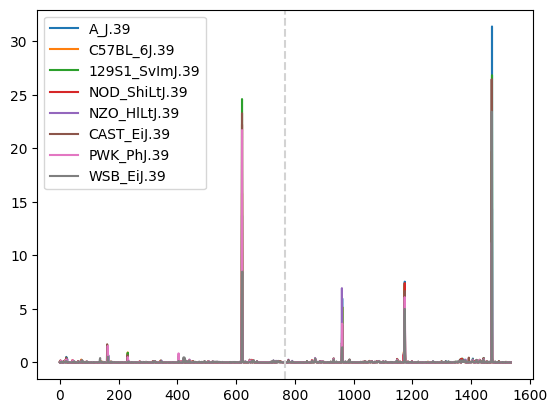

In [15]:
res_Trim5.plot()
pred_loc =768 
plt.axvline(x = pred_loc, color = 'lightgrey', ls='--')

#res_Trim5.iloc[pred_loc-2:pred_loc+12].plot()
#plt.axvline(x = pred_loc, color = 'lightgrey', ls='--')

Spearman ranking correlation at bin  768 : 0.7380952380952381
Pearson correlation at bin:  768 : 0.8571009463972142


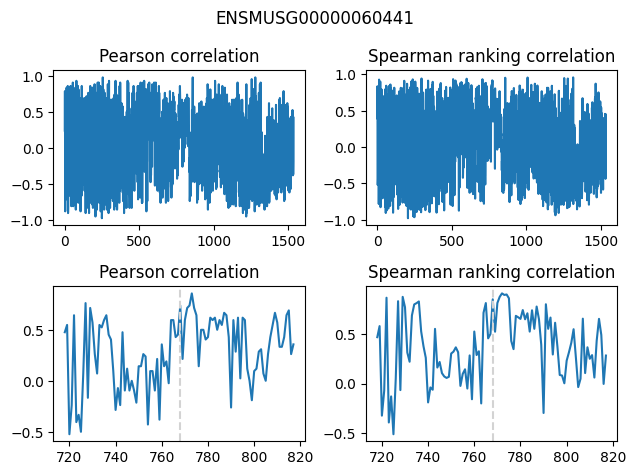

In [16]:
cal_bin_corr(res_Trim5, gene_id, c2eff, pred_loc)

In [17]:
c2eff1.loc[gene_id]

lod               219.406242
A_J.39             -1.529422
C57BL_6J.39        -0.226830
129S1_SvImJ.39     -1.603182
NOD_ShiLtJ.39      -0.329220
NZO_HlLtJ.39        2.120993
CAST_EiJ.39         0.941021
PWK_PhJ.39         -0.866122
WSB_EiJ.39          1.492763
pearson_corr        0.857101
spearman_corr       0.738095
Name: ENSMUSG00000060441, dtype: float64